In [32]:
### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import glob                 # return all file paths that match a specific pattern
import os                   # provide operating system-related functions
import pop_tools            # to mask region of interest
import gsw                  # compute potential density

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/'
files = sorted(glob.glob(path + '*.nc'))

# setting up of regional mask
grid_name = 'POP_gx1v7'
#setting up of regional mask
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7]},#, 9]}, 
                             'bounds': {'TLAT': [45., 66.],'TLONG': [280.0, 360.0]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

print('initialisation complete')

initialisation complete


# Plot location of metrics

In [76]:
import matplotlib.pyplot as plt
ds_plot = xr.open_dataset(files[0]).isel(time=slice(0,20)).mean('time').where(mask3d == 1).roll(nlon=-100)

In [84]:
def calculate_points_on_line(point1,point2,num):
    x1, y1 = point1
    x2, y2 = point2
    m = (y2 - y1)/(x2 - x1)
    b = y1 - (m * x1)
    x = np.linspace(x1, x2, num=num)
    y = m * x + b
    return x, y

def cross_section(ds, start_point, end_point, number_of_points):

    # Compute array of points on the line
    x, y = calculate_points_on_line(start_point, end_point, num=number_of_points)

    # prepare empty arra‚
    i_nlats = np.zeros(len(y))
    i_nlons = np.zeros(len(y))
    
    # retrieve numpy arrays from ds U coordinates
    ULAT = ds.ULAT.roll(nlon=-100).values
    ULONG = ds.ULONG.roll(nlon=-100).values

    for i in range(len(y)):
        target_ulat = y[i]
        target_ulong = (x[i] + 360) % 360

        # Calculate the absolute differences between the target values and ULAT, ULONG
        ulat_diff = np.abs(ULAT - target_ulat)
        ulong_diff = np.abs(ULONG - target_ulong)

        # Calculate the total difference
        total_diff = ulat_diff + ulong_diff

        # Find the indices of the minimum total difference
        min_index = np.unravel_index(np.nanargmin(total_diff), total_diff.shape)
        i_nlats[i] = min_index[0]
        i_nlons[i] = min_index[1]

    # Combine nlat and nlon arrays into a single array of tuples
    tuples = np.column_stack((i_nlats, i_nlons))

    # Find the unique tuples
    unique_tuples = np.unique(tuples, axis=0)

    # Separate the unique tuples back into nlat and nlon arrays
    unique_nlat = unique_tuples[:, 0]
    unique_nlon = unique_tuples[:, 1]
    
    # convert indices to integers (don't know why they aren't)
    nlats = unique_nlat.astype(int)
    nlons = unique_nlon.astype(int)
    
    return nlats, nlons

In [85]:
# define start and end points of array 
point_OSNAP_west = (-55, 53)
point_OSNAP_center = (-44, 60)
point_OSNAP_east = (-7, 56)

east_nlats, east_nlons = cross_section(ds_plot, point_OSNAP_center, point_OSNAP_east, 60)
west_nlats, west_nlons = cross_section(ds_plot, point_OSNAP_west, point_OSNAP_center, 40)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


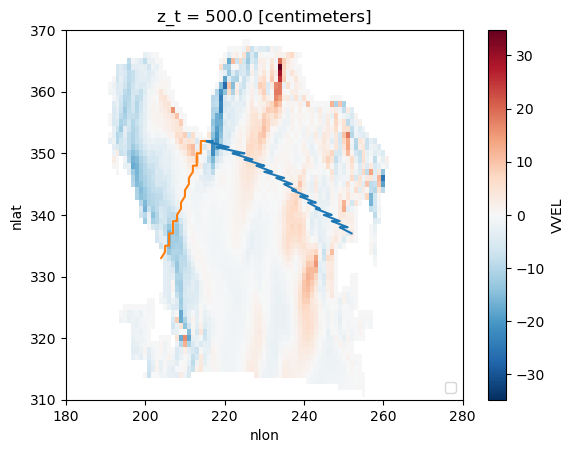

In [92]:
ds_plot.VVEL.isel(z_t=0).plot()

plt.plot(east_nlons, east_nlats)
plt.plot(west_nlons, west_nlats)

plt.xlim([180, 280])
plt.ylim([310, 370])

plt.legend(loc='lower right')

plt.show()

## Compute metrics

In [87]:
def BSF(ds, east_nlons, east_nlats, west_nlons, west_nlats):
    
    ## compute barotropic streamfunction
    bsf_ds = (ds.VVEL * ds.dz * ds.DXU).sum(dim='z_t').cumsum(dim='nlon')
    # compute crossections within BSF ds
    east_crossection_ds = bsf_ds.isel(nlon=east_nlons, nlat=east_nlats)
    west_crossection_ds = bsf_ds.isel(nlon=west_nlons, nlat=west_nlats)
    
    # find minimum overturning
    bsf_min = np.min(bsf_ds.values)
    # fins minimum of BSF on OSNAP east
    bsf_east = east_crossection_ds.min(('nlon','nlat')).values
    # find minimum of BSF on OSNAP west
    bsf_west = west_crossection_ds.min(('nlon','nlat')).values

    #return bsf_ds
    return bsf_min*-1e-12, bsf_east*-1e-12, bsf_west*-1e-12, bsf_ds

In [88]:
east_nlats, east_nlons = cross_section(ds_plot, point_OSNAP_center, point_OSNAP_east, 60)
west_nlats, west_nlons = cross_section(ds_plot, point_OSNAP_west, point_OSNAP_center, 40)

### COMPUTATION ###
i =0
t =0

# load file
ds = xr.open_dataset(files[i]).isel(time=t).where(mask3d == 1).roll(nlon=-100)
print('files loaded')

bsf_min, bsf_east, bsf_west, bsf_ds = BSF(ds, east_nlons, east_nlats, west_nlons, west_nlats)
#bsf_ds = BSF(ds, east_nlons, east_nlats, west_nlons, west_nlats)
print('metrics computed')    

files loaded
metrics computed
